In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import holidays_co

from pytrends.request import TrendReq


In [2]:
def remove_weekly_cycle(df):
    col_name = df.columns[0]

    week_cl = df.groupby(by=[df.index.weekday]).agg(['mean', 'std'])
    week_cl.index.set_names(['weekday'], inplace=True)

    data_no_cl = pd.DataFrame(index=df.index, columns=[f'{col_name}_no_cl'])

    for date in df.index:

        weekday = date.weekday()

        mean_cl = week_cl.loc[weekday, (col_name, 'mean')]
        std_cl = week_cl.loc[weekday, (col_name, 'std')]

        data_no_cl.loc[date, f'{col_name}_no_cl'] = (df.loc[date, col_name] - mean_cl)/std_cl

    data_no_cl = data_no_cl.astype(float)

    return data_no_cl, week_cl

def make_lag_correlations_two_varaibles(df_no_lag, df_lag, n_shifts, date_start, date_end, method='spearman'):
    corrs = pd.concat(
        [df_no_lag] + [df_lag.shift(shift) for shift in range(0, n_shifts)], axis=1
    ).loc[date_start:date_end].corr(method=method)

    corrs = corrs.loc[:, [df_no_lag.columns[0]]].iloc[1:].reset_index(drop=True)

    return corrs

In [3]:
data = pd.DataFrame(index=pd.date_range('2012-01-01', '2018-06-30', freq='D'))

## Datos registros RUNT

In [4]:
data_ra = pd.read_csv('./data/raw/registros_autos_entrenamiento - Hoja1.csv', index_col=0)
data_ra.index = pd.to_datetime(data_ra.index, format='%d/%m/%Y')
data_ra.columns = ['value']
data = pd.concat([data, data_ra], axis=1)
data

,value
2012-01-01,0.0
2012-01-02,188.0
2012-01-03,482.0
2012-01-04,927.0
2012-01-05,1159.0
...,...
2018-06-26,NaN
2018-06-27,NaN
2018-06-28,NaN
2018-06-29,NaN


<AxesSubplot:xlabel='Fecha'>

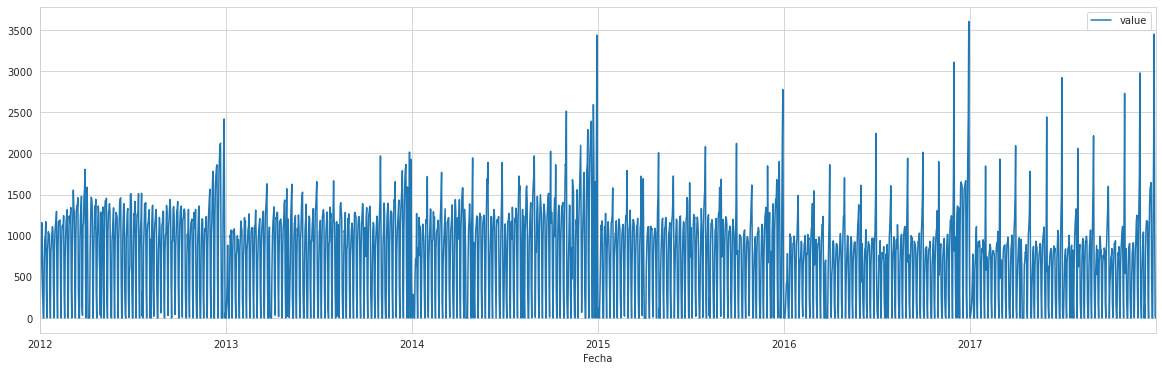

In [5]:
data_ra.plot(figsize=(20, 6))

### Anomalías registros RUNT

In [6]:
data_ra_no_cl, ra_week_cl = remove_weekly_cycle(data_ra)

data = pd.concat([data, data_ra_no_cl], axis=1)
data

,value,value_no_cl
2012-01-01,0.0,-0.353354
2012-01-02,188.0,-1.129851
2012-01-03,482.0,-1.395093
2012-01-04,927.0,-0.559771
2012-01-05,1159.0,0.012938
...,...,...
2018-06-26,NaN,NaN
2018-06-27,NaN,NaN
2018-06-28,NaN,NaN
2018-06-29,NaN,NaN


<AxesSubplot:>

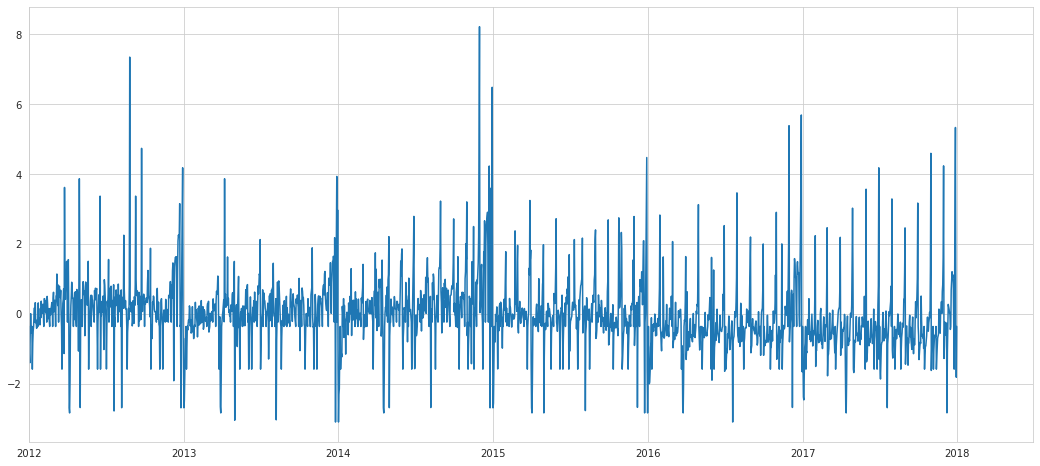

In [7]:
data.loc[:, 'value_no_cl'].plot(figsize=(18, 8))

## Variables relacionadas con fechas

### sin y cos

In [8]:
data.loc[:, 'cos_month'] = np.cos((2 * np.pi * data.index.month)/12)
data.loc[:, 'sin_month'] = np.sin((2 * np.pi * data.index.month)/12)
data.loc[:, 'cos_n_week'] = np.cos((2 * np.pi * data.index.isocalendar().week)/52)
data.loc[:, 'sin_n_week'] = np.sin((2 * np.pi * data.index.isocalendar().week)/52)
data.loc[:, 'cos_weekday'] = np.cos((2 * np.pi * data.index.weekday)/7)
data.loc[:, 'sin_weekday'] = np.sin((2 * np.pi * data.index.weekday)/7)

In [9]:
data

,value,value_no_cl,cos_month,sin_month,cos_n_week,sin_n_week,cos_weekday,sin_weekday
2012-01-01,0.0,-0.353354,0.866025,5.000000e-01,1.0,0.0,0.623490,-0.781831
2012-01-02,188.0,-1.129851,0.866025,5.000000e-01,0.992709,0.120537,1.000000,0.000000
2012-01-03,482.0,-1.395093,0.866025,5.000000e-01,0.992709,0.120537,0.623490,0.781831
2012-01-04,927.0,-0.559771,0.866025,5.000000e-01,0.992709,0.120537,-0.222521,0.974928
2012-01-05,1159.0,0.012938,0.866025,5.000000e-01,0.992709,0.120537,-0.900969,0.433884
...,...,...,...,...,...,...,...,...
2018-06-26,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,0.623490,0.781831
2018-06-27,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,-0.222521,0.974928
2018-06-28,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,-0.900969,0.433884
2018-06-29,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,-0.900969,-0.433884


### Días festivos

In [10]:
index_data_holidays = pd.date_range('2011-01-01', '2018-12-31', freq='D')
data_holidays = pd.DataFrame(
    data=np.zeros(len(index_data_holidays)), index=index_data_holidays, columns=['holiday']
)

for year in range(2011, 2019):
    holidays = [pd.Timestamp(ii.date) for ii in holidays_co.get_colombia_holidays_by_year(year)]

    for hd in holidays:
        data_holidays.loc[hd, 'holiday'] = 1

data_holidays = pd.concat([data_holidays, data_holidays.shift(1)], axis=1)
data_holidays.columns = ['holiday', 'day_before_holiday']

data.loc[:, 'holiday'] = data_holidays.loc['2012-01-01':'2018-06-30', 'holiday']
data.loc[:, 'day_before_holiday'] = data_holidays.loc['2012-01-01':'2018-06-30', 'day_before_holiday']
data

,value,value_no_cl,cos_month,sin_month,cos_n_week,sin_n_week,cos_weekday,sin_weekday,holiday,day_before_holiday
2012-01-01,0.0,-0.353354,0.866025,5.000000e-01,1.0,0.0,0.623490,-0.781831,1.0,0.0
2012-01-02,188.0,-1.129851,0.866025,5.000000e-01,0.992709,0.120537,1.000000,0.000000,0.0,1.0
2012-01-03,482.0,-1.395093,0.866025,5.000000e-01,0.992709,0.120537,0.623490,0.781831,0.0,0.0
2012-01-04,927.0,-0.559771,0.866025,5.000000e-01,0.992709,0.120537,-0.222521,0.974928,0.0,0.0
2012-01-05,1159.0,0.012938,0.866025,5.000000e-01,0.992709,0.120537,-0.900969,0.433884,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2018-06-26,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,0.623490,0.781831,0.0,0.0
2018-06-27,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,-0.222521,0.974928,0.0,0.0
2018-06-28,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,-0.900969,0.433884,0.0,0.0
2018-06-29,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,-0.900969,-0.433884,0.0,0.0


### Semana con día festivo

In [11]:
holidays_grouped = data.loc[:, ['holiday']].groupby(pd.Grouper(freq='W-SUN'))
data_week_with_holiday = pd.DataFrame(index=data.index)

for aux, (name, group) in enumerate(holidays_grouped):

    contains_holiday = int(group.any()[0])
    data_week_with_holiday.loc[group.index, 'week_with_holiday'] = contains_holiday

data = pd.concat([data, data_week_with_holiday], axis=1)
data

,value,value_no_cl,cos_month,sin_month,cos_n_week,sin_n_week,cos_weekday,sin_weekday,holiday,day_before_holiday,week_with_holiday
2012-01-01,0.0,-0.353354,0.866025,5.000000e-01,1.0,0.0,0.623490,-0.781831,1.0,0.0,1.0
2012-01-02,188.0,-1.129851,0.866025,5.000000e-01,0.992709,0.120537,1.000000,0.000000,0.0,1.0,0.0
2012-01-03,482.0,-1.395093,0.866025,5.000000e-01,0.992709,0.120537,0.623490,0.781831,0.0,0.0,0.0
2012-01-04,927.0,-0.559771,0.866025,5.000000e-01,0.992709,0.120537,-0.222521,0.974928,0.0,0.0,0.0
2012-01-05,1159.0,0.012938,0.866025,5.000000e-01,0.992709,0.120537,-0.900969,0.433884,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-06-26,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,0.623490,0.781831,0.0,0.0,0.0
2018-06-27,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,-0.222521,0.974928,0.0,0.0,0.0
2018-06-28,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,-0.900969,0.433884,0.0,0.0,0.0
2018-06-29,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,-0.900969,-0.433884,0.0,0.0,0.0


## TRM

In [12]:
data_trm_raw = pd.read_csv('./data/raw/Tasa_de_Cambio_Representativa_del__Mercado_-Historico.csv')
data_trm_raw.loc[:, 'VIGENCIADESDE'] = pd.to_datetime(data_trm_raw.loc[:, 'VIGENCIADESDE'], format='%d/%m/%Y')
data_trm_raw.loc[:, 'VIGENCIAHASTA'] = pd.to_datetime(data_trm_raw.loc[:, 'VIGENCIAHASTA'], format='%d/%m/%Y')

data_trm_raw

,VALOR,UNIDAD,VIGENCIADESDE,VIGENCIAHASTA
0,2850.98,COP,2002-10-09,2002-10-09
1,2854.04,COP,2002-10-10,2002-10-10
2,2870.63,COP,2002-10-11,2002-10-11
3,2861.16,COP,2002-10-12,2002-10-15
4,2852.99,COP,2002-10-16,2002-10-16
...,...,...,...,...
7347,3912.15,COP,2022-06-17,2022-06-17
7348,3905.05,COP,2022-06-18,2022-06-21
7349,4026.92,COP,2022-06-22,2022-06-22
7350,4026.52,COP,2022-06-23,2022-06-23


In [13]:
data_trm = pd.DataFrame(columns=['trm'])

for aux, ii in enumerate(data_trm_raw.index):
    date_start = data_trm_raw.loc[ii, 'VIGENCIADESDE']
    date_end = data_trm_raw.loc[ii, 'VIGENCIAHASTA']
    value = data_trm_raw.loc[ii, 'VALOR']

    date_range = pd.date_range(date_start, date_end, freq='D')

    df_tmp = pd.DataFrame(data=np.ones(len(date_range))*value, index=date_range, columns=['trm'])

    data_trm = pd.concat([data_trm, df_tmp], axis=0)

data_trm.index = pd.to_datetime(data_trm.index)
data_trm = data_trm.sort_index()
data_trm = data_trm.astype(float)
data_trm = data_trm.asfreq('D')

data_trm = data_trm.rolling(window=7).mean()

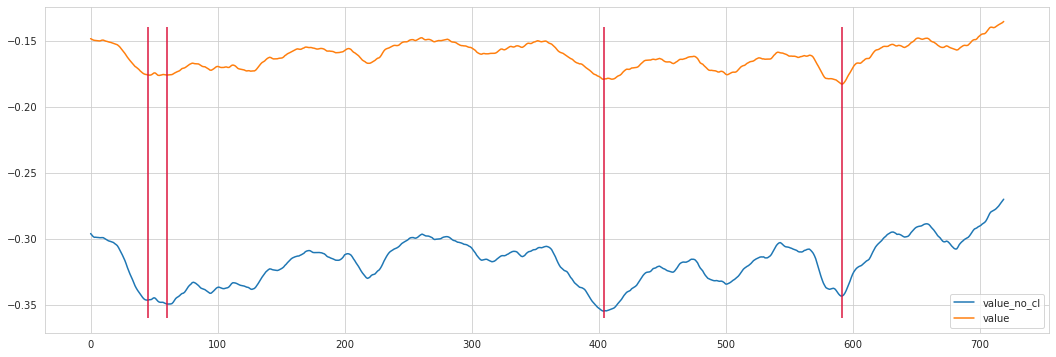

In [14]:
corrs_trm_ra_no_cl = make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value_no_cl']], df_lag=data_trm, n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
)

corrs_trm_ra = make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value']], df_lag=data_trm, n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
)

fig, ax = plt.subplots(figsize=(18, 6))
corrs_trm_ra_no_cl.plot(ax=ax)
corrs_trm_ra.plot(ax=ax)
plt.vlines(x = 45, ymin = -0.14, ymax = -0.36, color='crimson')
plt.vlines(x = 60, ymin = -0.14, ymax = -0.36, color='crimson')
plt.vlines(x = 404, ymin = -0.14, ymax = -0.36, color='crimson')
plt.vlines(x = 592, ymin = -0.14, ymax = -0.36, color='crimson')
plt.show()
plt.close('all')

In [15]:
list_shifts = [45, 60, 404, 592]
data_trm_shifted = pd.concat([data_trm.shift(shift) for shift in list_shifts], axis=1)
data_trm_shifted.columns = [f'trm_shift_{ii}' for ii in list_shifts]
data_trm_shifted = data_trm_shifted.loc['2012-01-01':'2018-06-30']

data = pd.concat([data, data_trm_shifted], axis=1)

data_trm = data_trm.loc['2011-01-01':'2019-12-31']

In [16]:
data

,value,value_no_cl,cos_month,sin_month,cos_n_week,sin_n_week,cos_weekday,sin_weekday,holiday,day_before_holiday,week_with_holiday,trm_shift_45,trm_shift_60,trm_shift_404,trm_shift_592
2012-01-01,0.0,-0.353354,0.866025,5.000000e-01,1.0,0.0,0.623490,-0.781831,1.0,0.0,1.0,1913.694286,1870.427143,1875.821429,1967.834286
2012-01-02,188.0,-1.129851,0.866025,5.000000e-01,0.992709,0.120537,1.000000,0.000000,0.0,1.0,0.0,1913.291429,1872.078571,1877.515714,1972.224286
2012-01-03,482.0,-1.395093,0.866025,5.000000e-01,0.992709,0.120537,0.623490,0.781831,0.0,0.0,0.0,1913.834286,1878.155714,1879.420000,1980.518571
2012-01-04,927.0,-0.559771,0.866025,5.000000e-01,0.992709,0.120537,-0.222521,0.974928,0.0,0.0,0.0,1914.377143,1885.678571,1882.747143,1984.850000
2012-01-05,1159.0,0.012938,0.866025,5.000000e-01,0.992709,0.120537,-0.900969,0.433884,0.0,0.0,0.0,1914.920000,1893.201429,1887.218571,1989.181429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-26,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,0.623490,0.781831,0.0,0.0,0.0,2839.421429,2784.524286,2905.782857,3054.088571
2018-06-27,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,-0.222521,0.974928,0.0,0.0,0.0,2836.655714,2791.427143,2905.531429,3058.334286
2018-06-28,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,-0.900969,0.433884,0.0,0.0,0.0,2833.890000,2798.330000,2901.354286,3062.580000
2018-06-29,NaN,NaN,-1.000000,1.224647e-16,-1.0,-0.0,-0.900969,-0.433884,0.0,0.0,0.0,2834.868571,2805.232857,2897.177143,3066.825714


<AxesSubplot:>

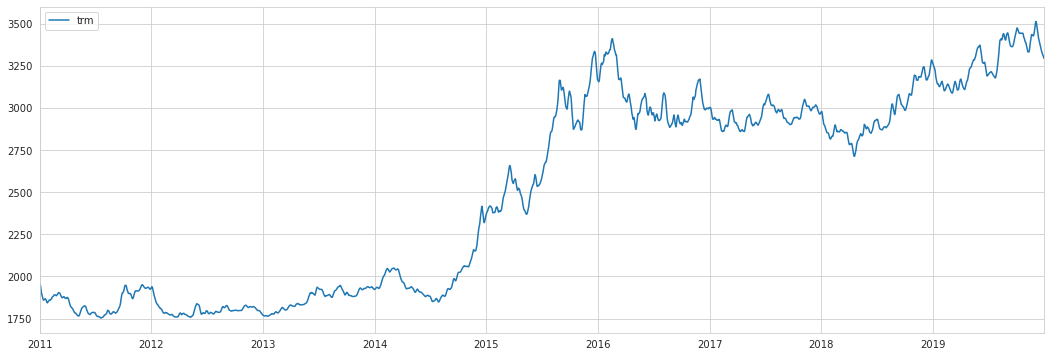

In [17]:
data_trm.plot(figsize=(18, 6))

## Google Trends

In [18]:
pytrends = TrendReq(hl="es")

In [19]:
# # #automovil, moto, RUNT
# search = ['RUNT']
# gt_automovil = pytrends.get_historical_interest(search, year_start=2010, month_start=1, day_start=1, hour_start=0, year_end=2019, month_end=12, day_end=31, hour_end=23, cat=0, geo='CO', gprop='', sleep=1)
#
# gt_automovil.to_csv(f'./data/clean/google_trends_{search[0]}.csv')

<AxesSubplot:xlabel='date'>

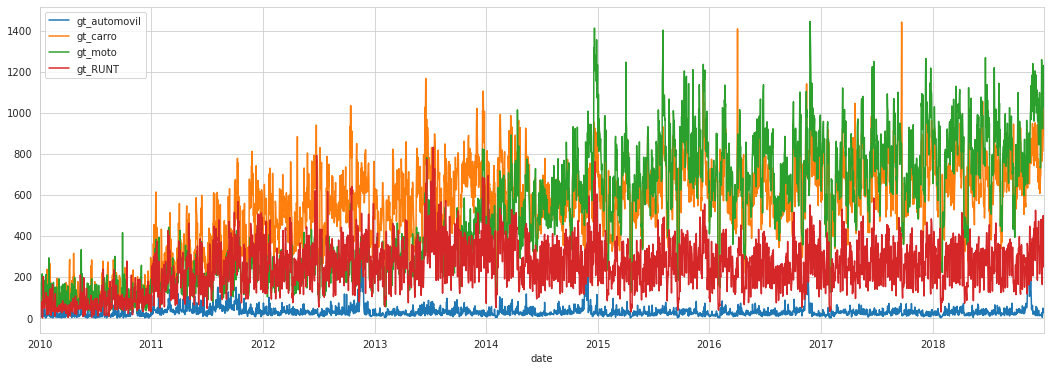

In [20]:
data_gt = pd.read_csv('./data/clean/google_trends2.csv', index_col=0)
data_gt.index = pd.to_datetime(data_gt.index)
data_gt = data_gt.drop(columns='isPartial')
data_gt = data_gt.resample('1D').sum()
data_gt.columns = [f'gt_{ii}' for ii in data_gt.columns]

# data_gt
data_gt.plot(figsize=(18, 6))

In [21]:
data_gt_no_cl = pd.DataFrame()
data_gt_week_cl = pd.DataFrame()

for col in data_gt.columns:
    data_no_cl_tmp, week_cl_tmp = remove_weekly_cycle(data_gt.loc[:, [col]])

    data_gt_no_cl = pd.concat([data_gt_no_cl, data_no_cl_tmp], axis=1)
    data_gt_week_cl = pd.concat([data_gt_week_cl, week_cl_tmp], axis=1)


<AxesSubplot:xlabel='date'>

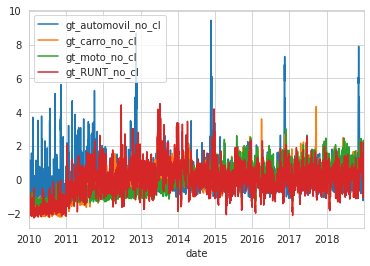

In [22]:
data_gt_no_cl.plot()

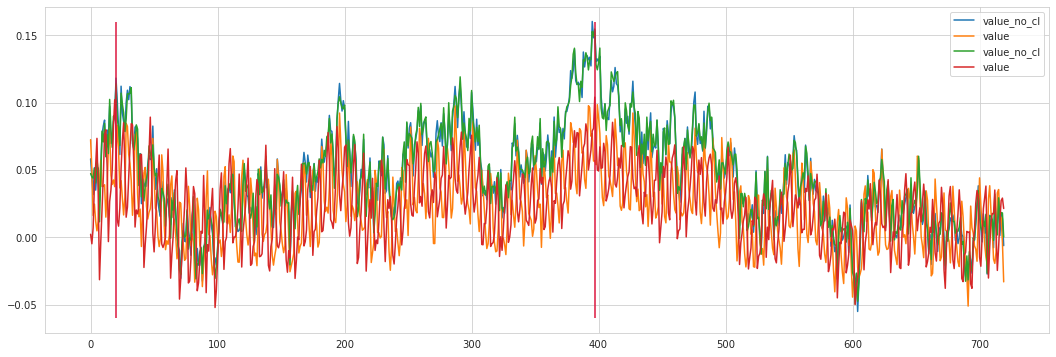

In [23]:
fig, ax = plt.subplots(figsize=(18, 6))

var = 'gt_automovil'

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value_no_cl']], df_lag=data_gt.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value']], df_lag=data_gt.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

var = f'{var}_no_cl'

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value_no_cl']], df_lag=data_gt_no_cl.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value']], df_lag=data_gt_no_cl.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

plt.vlines(x=20, ymin=-0.06, ymax=0.16, color='crimson')
plt.vlines(x=397, ymin=-0.06, ymax=0.16, color='crimson')

plt.show()
plt.close('all')

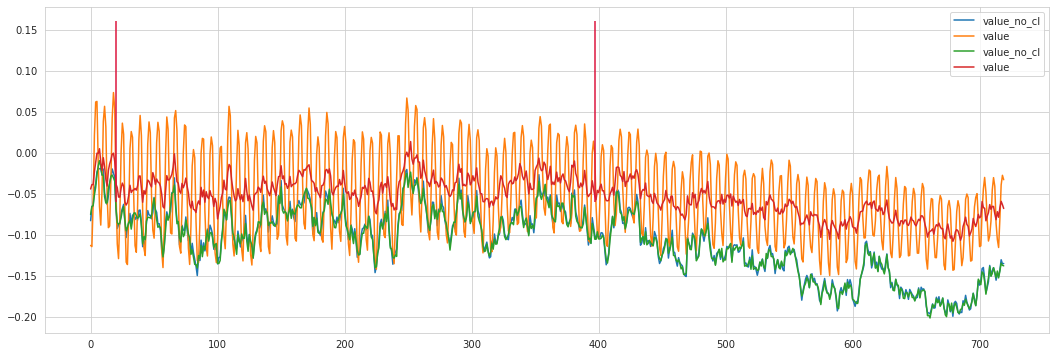

In [24]:
fig, ax = plt.subplots(figsize=(18, 6))

var = 'gt_carro'

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value_no_cl']], df_lag=data_gt.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value']], df_lag=data_gt.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

var = f'{var}_no_cl'

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value_no_cl']], df_lag=data_gt_no_cl.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value']], df_lag=data_gt_no_cl.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

plt.vlines(x=20, ymin=-0.06, ymax=0.16, color='crimson')
plt.vlines(x=397, ymin=-0.06, ymax=0.16, color='crimson')

plt.show()
plt.close('all')

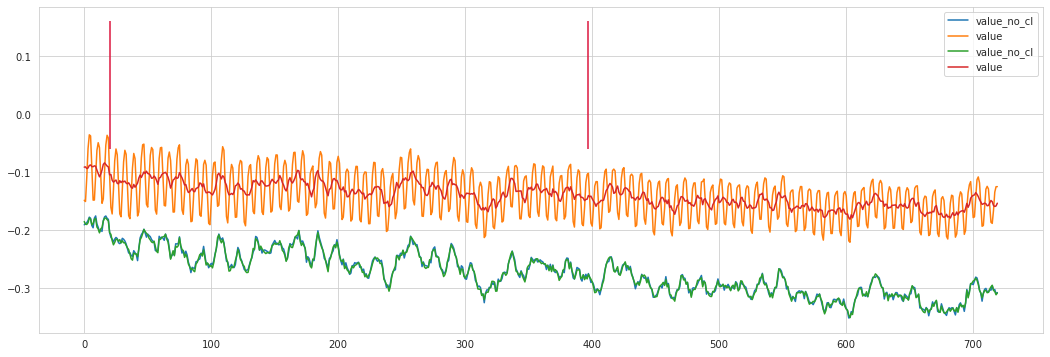

In [25]:
fig, ax = plt.subplots(figsize=(18, 6))

var = 'gt_moto'

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value_no_cl']], df_lag=data_gt.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value']], df_lag=data_gt.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

var = f'{var}_no_cl'

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value_no_cl']], df_lag=data_gt_no_cl.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value']], df_lag=data_gt_no_cl.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

plt.vlines(x=20, ymin=-0.06, ymax=0.16, color='crimson')
plt.vlines(x=397, ymin=-0.06, ymax=0.16, color='crimson')

plt.show()
plt.close('all')

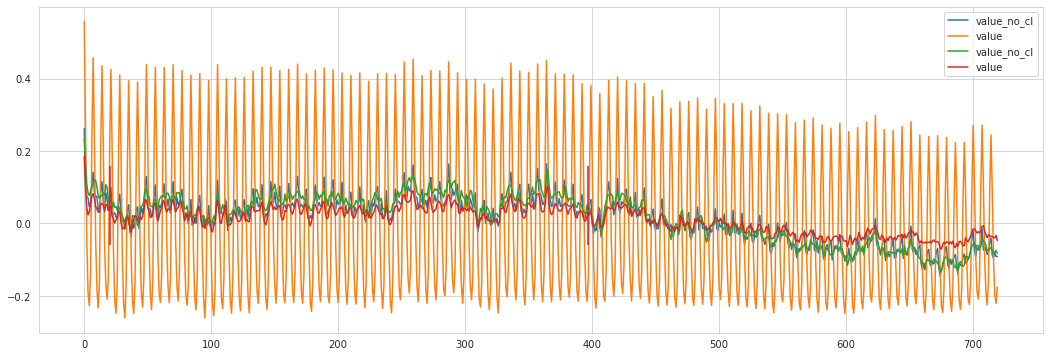

In [26]:
fig, ax = plt.subplots(figsize=(18, 6))

var = 'gt_RUNT'

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value_no_cl']], df_lag=data_gt.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value']], df_lag=data_gt.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

var = f'{var}_no_cl'

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value_no_cl']], df_lag=data_gt_no_cl.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

make_lag_correlations_two_varaibles(
    df_no_lag=data.loc[:, ['value']], df_lag=data_gt_no_cl.loc[:, var], n_shifts=720,
    date_start='2012-01-01', date_end='2017-12-31', method='spearman'
).plot(ax=ax)

plt.vlines(x=20, ymin=-0.06, ymax=0.16, color='crimson')
plt.vlines(x=397, ymin=-0.06, ymax=0.16, color='crimson')

plt.show()
plt.close('all')

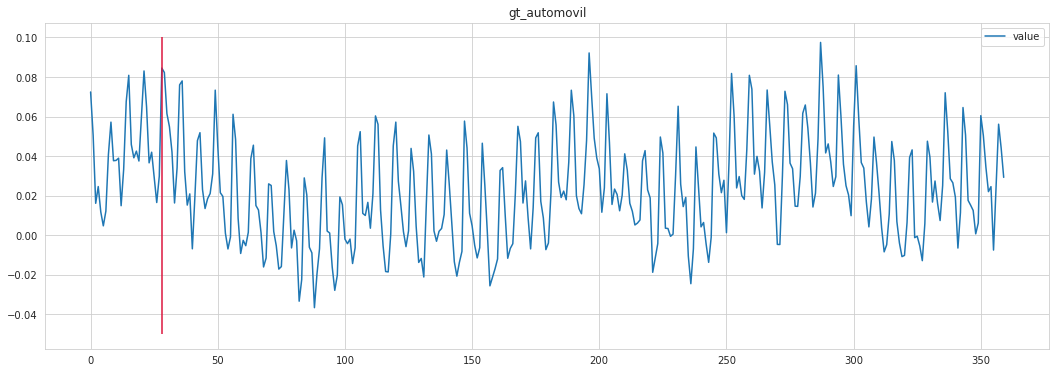

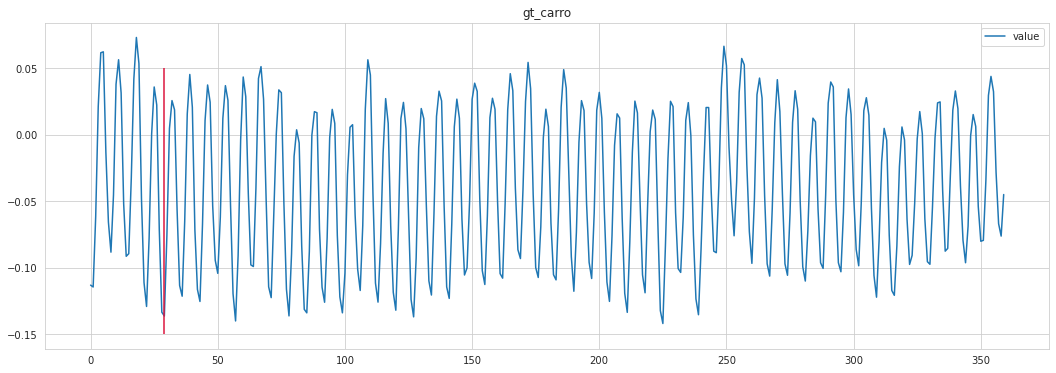

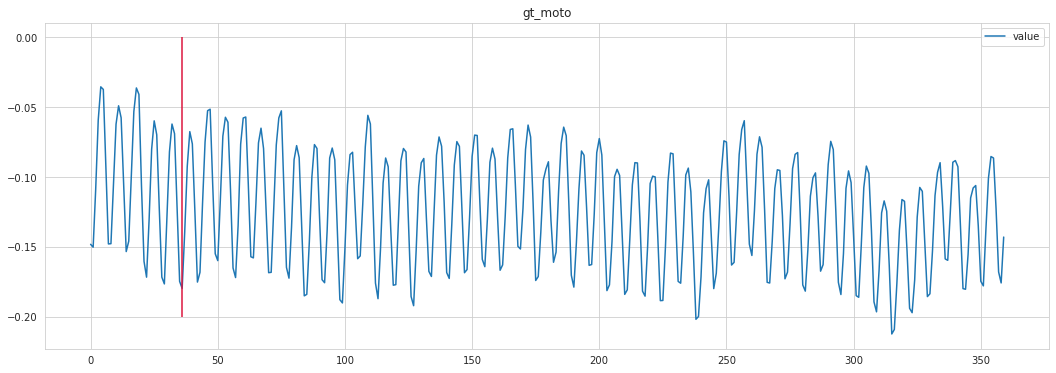

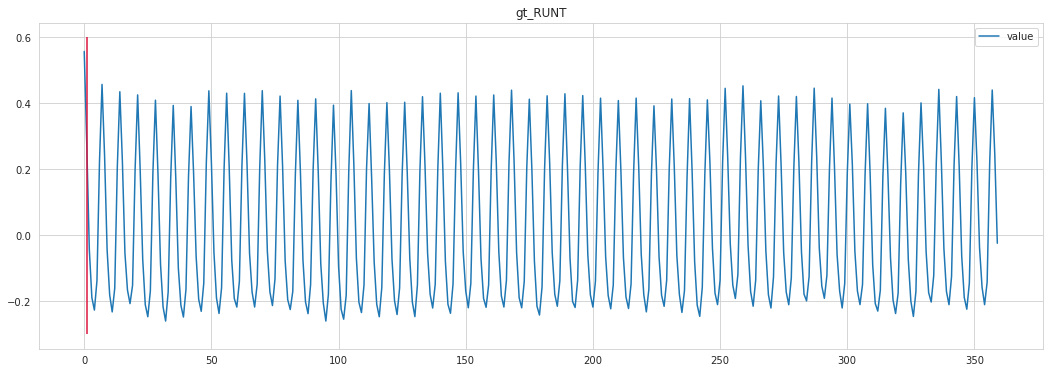

In [27]:
var = 'gt_automovil'

corrs_gt = pd.concat(
    [data.loc[:, ['value']]] + [data_gt.loc[:, var].shift(shift) for shift in range(0, 360)], axis=1
).loc['2012-01-01':'2017-12-31'].corr(method='spearman')

corrs_gt.loc['value'].iloc[1:].reset_index().plot(figsize=(18, 6))
plt.vlines(x = 28, ymin = -0.05, ymax = 0.1, color='crimson')
# plt.vlines(x = 392, ymin = 0, ymax = 0.15, color='crimson')
plt.title(var)
plt.show()
plt.close('all')

var = 'gt_carro'

corrs_gt = pd.concat(
    [data.loc[:, ['value']]] + [data_gt.loc[:, var].shift(shift) for shift in range(0, 360)], axis=1
).loc['2012-01-01':'2017-12-31'].corr(method='spearman')

corrs_gt.loc['value'].iloc[1:].reset_index().plot(figsize=(18, 6))
plt.vlines(x = 29, ymin = -0.15, ymax = 0.05, color='crimson')
# plt.vlines(x = 197, ymin = -0.15, ymax = 0.05, color='crimson')
plt.title(var)
plt.show()
plt.close('all')

var = 'gt_moto'

corrs_gt = pd.concat(
    [data.loc[:, ['value']]] + [data_gt.loc[:, var].shift(shift) for shift in range(0, 360)], axis=1
).loc['2012-01-01':'2017-12-31'].corr(method='spearman')

corrs_gt.loc['value'].iloc[1:].reset_index().plot(figsize=(18, 6))
plt.vlines(x = 36, ymin = -0.2, ymax = 0, color='crimson')
# plt.vlines(x = 392, ymin = 0, ymax = 0.15, color='crimson')
plt.title(var)
plt.show()
plt.close('all')

var = 'gt_RUNT'

corrs_gt = pd.concat(
    [data.loc[:, ['value']]] + [data_gt.loc[:, var].shift(shift) for shift in range(0, 360)], axis=1
).loc['2012-01-01':'2017-12-31'].corr(method='spearman')

corrs_gt.loc['value'].iloc[1:].reset_index().plot(figsize=(18, 6))
plt.vlines(x = 1, ymin = 0.6, ymax = -0.3, color='crimson')
# plt.vlines(x = 392, ymin = 0, ymax = 0.15, color='crimson')
plt.title(var)
plt.show()
plt.close('all')

In [28]:
data_gt_shifted = pd.DataFrame()
for (var, shift) in [('gt_carro', 29), ('gt_moto', 36), ('gt_RUNT', 1)]:
    data_gt_shifted = pd.concat([data_gt_shifted, data_gt.loc[:, [var]].shift(shift)], axis=1)

data_gt_shifted = data_gt_shifted.loc['2012-01-01':'2019-12-31']
data = pd.concat([data, data_gt_shifted], axis=1)
data

,value,value_no_cl,cos_month,sin_month,cos_n_week,sin_n_week,cos_weekday,sin_weekday,holiday,day_before_holiday,week_with_holiday,trm_shift_45,trm_shift_60,trm_shift_404,trm_shift_592,gt_carro,gt_moto,gt_RUNT
2012-01-01,0.0,-0.353354,0.866025,0.5,1.0,0.0,0.623490,-0.781831,1.0,0.0,1.0,1913.694286,1870.427143,1875.821429,1967.834286,468.0,339.0,148.0
2012-01-02,188.0,-1.129851,0.866025,0.5,0.992709,0.120537,1.000000,0.000000,0.0,1.0,0.0,1913.291429,1872.078571,1877.515714,1972.224286,557.0,297.0,125.0
2012-01-03,482.0,-1.395093,0.866025,0.5,0.992709,0.120537,0.623490,0.781831,0.0,0.0,0.0,1913.834286,1878.155714,1879.420000,1980.518571,344.0,266.0,371.0
2012-01-04,927.0,-0.559771,0.866025,0.5,0.992709,0.120537,-0.222521,0.974928,0.0,0.0,0.0,1914.377143,1885.678571,1882.747143,1984.850000,516.0,327.0,296.0
2012-01-05,1159.0,0.012938,0.866025,0.5,0.992709,0.120537,-0.900969,0.433884,0.0,0.0,0.0,1914.920000,1893.201429,1887.218571,1989.181429,323.0,367.0,408.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,743.0,1005.0,437.0
2018-12-28,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,873.0,1184.0,468.0
2018-12-29,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,779.0,1022.0,499.0
2018-12-30,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,870.0,1240.0,431.0


In [29]:
data.to_csv('./data/processed/dataset.csv')